In [39]:
%pip install torch torch_sparse pyglib torch_geometric torch_scatter imblearn --prefer-binary

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip3 uninstall -y keras && pip3 install keras>=3.0.0

Found existing installation: keras 2.13.1
Uninstalling keras-2.13.1:
  Successfully uninstalled keras-2.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires keras<2.14,>=2.13.1, but you have keras 3.0.4 which is incompatible.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.26.3 which is incompatible.


In [29]:
import random
import pickle
import os

import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.optimizers import Adam as KAdam

import torch
import torch_sparse
from torch_geometric.nn import GraphSAGE
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader, LinkNeighborLoader
from torch.optim import Adam
import torch.nn.functional as F

In [2]:
keras.__version__

'3.0.4'

In [3]:
df = pd.read_csv("chem_gene_onehotencoded.csv")
print(len(df))
df.head()

96338


,Unnamed: 0,# ChemicalName,ChemicalID,CasRN,GeneSymbol,GeneID,GeneForms,Organism,OrganismID,Interaction,...,increases^expression,increases^glucuronidation,increases^metabolic processing,increases^methylation,increases^mutagenesis,increases^oxidation,increases^phosphorylation,increases^reduction,increases^response to substance,increases^secretion
0,0,10074-G5,C534883,NaN,AR,367.0,protein,Homo sapiens,9606.0,10074-G5 results in decreased expression of AR...,...,0,0,0,0,0,0,0,0,0,0
1,2,10074-G5,C534883,NaN,MYC,4609.0,protein,Homo sapiens,9606.0,10074-G5 analog results in decreased expressio...,...,0,0,0,0,0,0,0,0,0,0
2,5,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone",C112297,NaN,KCNQ1,3784.0,protein,NaN,NaN,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthraceno...",...,0,0,0,0,0,0,0,0,0,0
3,6,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone",C112297,NaN,KCNQ2,3785.0,protein,Homo sapiens,9606.0,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthraceno...",...,0,0,0,0,0,0,0,0,0,0
4,8,"10,11-dihydro-10-hydroxycarbamazepine",C039775,NaN,CYP2C19,1557.0,protein,NaN,NaN,"10,11-dihydro-10-hydroxycarbamazepine results ...",...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.columns

Index(['Unnamed: 0', '# ChemicalName', 'ChemicalID', 'CasRN', 'GeneSymbol',
       'GeneID', 'GeneForms', 'Organism', 'OrganismID', 'Interaction',
       'InteractionActions', 'PubMedIDs', 'IA_list',
       'InteractionActionsEncoded', 'affects^activity', 'affects^binding',
       'affects^expression', 'affects^localization',
       'affects^metabolic processing', 'affects^response to substance',
       'decreases^activity', 'decreases^expression',
       'decreases^phosphorylation', 'decreases^response to substance',
       'increases^ADP-ribosylation', 'increases^abundance',
       'increases^activity', 'increases^chemical synthesis',
       'increases^cleavage', 'increases^expression',
       'increases^glucuronidation', 'increases^metabolic processing',
       'increases^methylation', 'increases^mutagenesis', 'increases^oxidation',
       'increases^phosphorylation', 'increases^reduction',
       'increases^response to substance', 'increases^secretion'],
      dtype='object')

In [5]:
unique_values_counts = df["InteractionActions"].value_counts()
unique_values_counts

InteractionActions
increases^expression               39634
decreases^expression               38118
affects^expression                  9517
decreases^activity                  1806
increases^activity                  1410
affects^binding                     1304
increases^phosphorylation            649
decreases^phosphorylation            473
increases^metabolic processing       354
affects^response to substance        296
increases^cleavage                   266
increases^ADP-ribosylation           266
affects^localization                 235
increases^glucuronidation            220
increases^chemical synthesis         200
increases^response to substance      200
decreases^response to substance      200
affects^metabolic processing         195
increases^secretion                  189
increases^oxidation                  169
increases^abundance                  144
increases^methylation                141
affects^activity                     137
increases^reduction                  1

In [6]:
graph_file_path = "graph.gexf"
G = nx.read_gexf(graph_file_path)

In [7]:
print(list(G.edges())[:5])

[('C534883', '367.0'), ('C534883', '4609.0'), ('C112297', '3784.0'), ('C112297', '3785.0'), ('C039775', '1557.0')]


In [8]:
node_mapping = {node: idx for idx, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)

edge_index = torch.tensor(list(G.edges)).t().contiguous()[:-1]
x = torch.eye(G.number_of_nodes())

In [9]:
print(list(G.nodes)[:5])
print(list(node_mapping.items())[:5])

[0, 1, 2, 3, 4]
[('C534883', 0), ('367.0', 1), ('4609.0', 2), ('C112297', 3), ('3784.0', 4)]


In [10]:
G.number_of_edges(), G.number_of_nodes()

(96338, 23189)

## If you have embeddings pickled, skip this section.

In [ ]:
data = Data(x=x, edge_index=edge_index)
torch.save(data, 'sage_embeddings_mainmapdata_object.pt')

data.train_mask = torch.randperm(G.number_of_nodes()) < 0.8
data.test_mask = ~data.train_mask

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
data.x = data.x.to(device)
data.train_mask = data.train_mask.to(device)
data.test_mask = data.test_mask.to(device)
data.edge_index = data.edge_index.to(device)

In [10]:
loader = LinkNeighborLoader(data, batch_size=32, shuffle=True,
                            neg_sampling_ratio=1.0, num_neighbors=[10, 10],
                            num_workers=4, persistent_workers=True)

model = GraphSAGE(
    in_channels=data.num_features,
    hidden_channels=64,
    num_layers=4,
    out_channels=64,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

def train():
    model.train()

    total_loss = total_examples = 0
    for data in tqdm(loader):
        data = data.to(device)
        optimizer.zero_grad()
        h = model(data.x, data.edge_index)

        h_src = h[data.edge_label_index[0]]
        h_dst = h[data.edge_label_index[1]]
        link_pred = (h_src * h_dst).sum(dim=-1)  # Inner product.

        loss = F.binary_cross_entropy_with_logits(link_pred, data.edge_label)
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * link_pred.numel()
        total_examples += link_pred.numel()

    return total_loss / total_examples

W0209 08:05:47.748089 15797 warnings.py:109] /opt/conda/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:60: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "



In [24]:
for epoch in range(10):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

  0%|          | 0/3011 [00:00<?, ?it/s]

Epoch: 00, Loss: 0.4146


  0%|          | 0/3011 [00:00<?, ?it/s]

Epoch: 01, Loss: 0.3976


  0%|          | 0/3011 [00:00<?, ?it/s]

Epoch: 02, Loss: 0.3972


  0%|          | 0/3011 [00:00<?, ?it/s]

Epoch: 03, Loss: 0.3933


  0%|          | 0/3011 [00:00<?, ?it/s]

Epoch: 04, Loss: 0.3898


  0%|          | 0/3011 [00:00<?, ?it/s]

Epoch: 05, Loss: 0.3946


  0%|          | 0/3011 [00:00<?, ?it/s]

Epoch: 06, Loss: 0.3919


  0%|          | 0/3011 [00:00<?, ?it/s]

Epoch: 07, Loss: 0.3911


  0%|          | 0/3011 [00:00<?, ?it/s]

Epoch: 08, Loss: 0.3874


  0%|          | 0/3011 [00:00<?, ?it/s]

Epoch: 09, Loss: 0.3990


## If you skipped above, continue here.

In [11]:
def make_dataset():
    if os.path.exists('positive_edges.txt'):
        f = open('positive_edges.txt', 'r').readlines()
        positive_edges = [list(map(int, x.split())) for x in f]
    else:
        positive_edges = list(zip(edge_index[0], edge_index[1]))
        with open('positive_edges.txt', 'w') as pos_file:
            pos_file.writelines([f'{x[0]} {x[1]}\n' for x in positive_edges])
    
    if os.path.exists('negative_edges.txt'):
        f = open('negative_edges.txt', 'r').readlines()
        negative_edges = [list(map(int, x.split())) for x in f]
    else:
        n_pos = edge_index.shape[1]
        negative_edges = set()
        n_neg = 0
        
        bar = tqdm(total=n_pos)
        while n_neg < n_pos:
            n1, n2 = random.sample(range(G.number_of_nodes()), 2)

            if (n1, n2) not in positive_edges and (n2, n1) not in positive_edges:
                negative_edges.add((n1, n2))

            n_neg += 1
            bar.update(1)
        
        negative_edges = list(negative_edges)

        # Save negative edges to a file
        with open('negative_edges.txt', 'w') as neg_file:
            neg_file.writelines([f'{x[0]} {x[1]}\n' for x in negative_edges])

    return positive_edges, negative_edges

In [12]:
list(G.edges(keys=True, data=True))[:5]

[(0, 1, 0, {'action': 'decreases^expression', 'id': '0'}),
 (0, 2, 0, {'action': 'decreases^expression', 'id': '1'}),
 (3, 4, 0, {'action': 'decreases^activity', 'id': '2'}),
 (3, 5, 0, {'action': 'decreases^activity', 'id': '3'}),
 (6, 7, 0, {'action': 'decreases^activity', 'id': '4'})]

In [13]:
def make_classification_dataset(): 
    if os.path.exists('X.npy') and os.path.exists('y.npy'):
        return np.load(open('X.npy', 'rb')), np.load(open('y.npy', 'rb'))
    else:
        if os.path.exists('sage_embeddings_mainmap.pkl'):
            with open('sage_embeddings_mainmap.pkl', 'rb') as f:
                emb_map = pickle.load(f)

            embeddings = np.array([v[1] for k, v in emb_map.items()])
            print(f'Loaded embeddings with shape {embeddings.shape}')
            assert len(embeddings) == len(G.nodes())
        else:
            loader = LinkNeighborLoader(data, batch_size=32, shuffle=True,
                                    neg_sampling_ratio=1.0, num_neighbors=[10, 10],
                                    num_workers=4, persistent_workers=True)

            embeddings = []
            print('Generating embeddings...')
            for batch in tqdm(loader):
                embeddings.extend(model(batch.x, batch.edge_index).detach().cpu().numpy().tolist())

            #embeddings = model(data.x, data.edge_index).detach().cpu().numpy()
            emb_map = {node: [idx, embeddings[idx]] for idx, node in enumerate(G.nodes())}
            reverse_map = {idx: [node, embeddings[idx]] for idx, node in enumerate(G.nodes())}

            print('Dumping embeddings...')
            with open('sage_embeddings_mainmap.pkl', 'wb') as f:
                pickle.dump(emb_map, f)

            with open('sage_embeddings_reversemap.pkl', 'wb') as f:
                pickle.dump(reverse_map, f)

        print('Generating dataset...')
        p, n = make_dataset()
        X_pos = np.array([np.hstack((embeddings[n1], embeddings[n2])) for n1, n2 in p])

        # Assuming one_hot_encoded_df contains the one-hot encoded columns
        interaction_actions_columns = [
            'affects^activity', 'affects^binding',
            'affects^expression', 'affects^localization',
            'affects^metabolic processing', 'affects^response to substance',
            'decreases^activity', 'decreases^expression',
            'decreases^phosphorylation', 'decreases^response to substance',
            'increases^ADP-ribosylation', 'increases^abundance',
            'increases^activity', 'increases^chemical synthesis',
            'increases^cleavage', 'increases^expression',
            'increases^glucuronidation', 'increases^metabolic processing',
            'increases^methylation', 'increases^mutagenesis', 'increases^oxidation',
            'increases^phosphorylation', 'increases^reduction',
            'increases^response to substance', 'increases^secretion'
        ]

        # Concatenate one-hot encoded columns into a single tensor
        y_pos = []

        start_column_index = 14
        end_column_index = len(df.columns)

        for source, target, key, data_ in G.edges(keys=True, data=True):
            id_value = int(data_['id'])
            concatenated_values = df.iloc[id_value, start_column_index:end_column_index + 1].values.tolist()
            y_pos.append(concatenated_values)

        X_neg = np.array([np.hstack((embeddings[n1], embeddings[n2])) for n1, n2 in n])
        y_neg =  np.zeros((len(X_neg), 26))

        X = np.vstack((X_pos, X_neg))
        y = np.concatenate((y_pos, y_neg))

        np.save('X.npy', X)
        np.save('y.npy', y)

        return X, y

In [14]:
X, y = make_classification_dataset()

In [15]:
print(len(X))
print(len(y))

192659
192659


In [16]:
X.shape, y.shape

((192659, 128), (192659, 26))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((144494, 128), (144494, 26), (48165, 128), (48165, 26))

In [19]:
smote = SMOTE()
y_train = np.argmax(y_train, axis=1)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [20]:
X_train.shape, y_train.shape

((1808325, 128), (1808325,))

In [21]:
y_train = to_categorical(y_train, num_classes=26)

In [22]:
del X, y
import gc
gc.collect()

112844

In [23]:
clf = Sequential([
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(26, activation='softmax')
])

In [24]:
clf.compile(optimizer=KAdam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

2024-02-09 09:31:14.561753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-09 09:31:14.627856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-09 09:31:14.630892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [25]:
history = clf.fit(X_train, y_train, batch_size=64, epochs=10)

2024-02-09 09:32:36.363922: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 925862400 exceeds 10% of free system memory.
2024-02-09 09:32:37.176902: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 925862400 exceeds 10% of free system memory.


Epoch 1/10


2024-02-09 09:32:40.125038: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55eb97545950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-09 09:32:40.125092: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-02-09 09:32:42.990191: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-09 09:32:50.341956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900


   85/28256 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - acc: 0.0345 - loss: 3.3502       

2024-02-09 09:32:55.097667: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28256/28256 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - acc: 0.1495 - loss: 2.9748
Epoch 2/10
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - acc: 0.2529 - loss: 2.6151
Epoch 3/10
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - acc: 0.2870 - loss: 2.4827
Epoch 4/10
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - acc: 0.3064 - loss: 2.4035
Epoch 5/10
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - acc: 0.3221 - loss: 2.3465
Epoch 6/10
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - acc: 0.3351 - loss: 2.3024
Epoch 7/10
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - acc: 0.3475 - loss: 2.2659
Epoch 8/10
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - acc: 0.3579 - loss: 2.2360
Epoch 9/10
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - acc: 0.3669 - loss: 2.2084
Epoch 10/10
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - acc: 0.3730 - loss: 2.1846


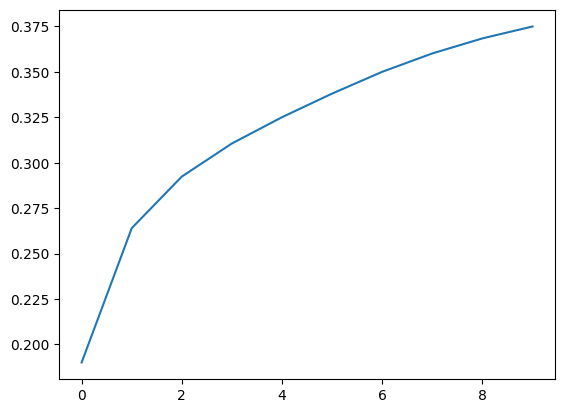

In [31]:
plt.plot(range(10), history.history['acc']);

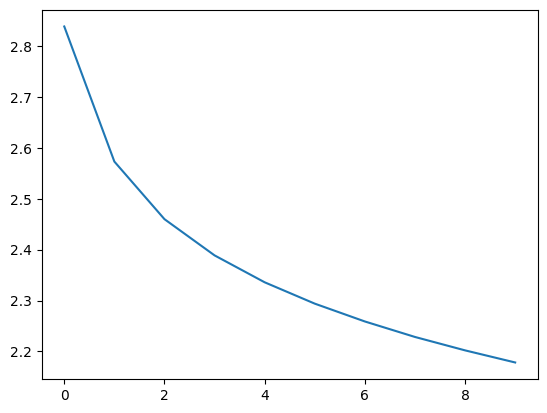

In [32]:
plt.plot(range(10), history.history['loss']);

In [33]:
history = clf.fit(X_train, y_train, batch_size=64, epochs=10)

2024-02-09 09:42:43.400679: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 925862400 exceeds 10% of free system memory.
2024-02-09 09:42:44.211684: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 925862400 exceeds 10% of free system memory.


Epoch 1/10
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - acc: 0.3800 - loss: 2.1616
Epoch 2/10
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - acc: 0.3850 - loss: 2.1442
Epoch 3/10
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - acc: 0.3900 - loss: 2.1254
Epoch 4/10
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - acc: 0.3942 - loss: 2.1116
Epoch 5/10
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - acc: 0.3972 - loss: 2.0969
Epoch 6/10
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - acc: 0.4006 - loss: 2.0836
Epoch 7/10
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - acc: 0.4045 - loss: 2.0692
Epoch 8/10
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - acc: 0.4066 - loss: 2.0606
Epoch 9/10
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - acc: 0.4087 - loss: 2.0516
Epoch 10/10
28256/28256 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - acc: 0.4124 - loss: 2.0400
